In [ ]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

from model import Model
import utils
from early_stopping import EarlyStopping
from gp import moving_average

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
# utils.set_seeds(7)

In [ ]:
behaviour_data, spikes = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data, spikes = [x[time_from:, :] for x in behaviour_data], [x[time_from:, :] for x in spikes]
num_trials, time_bins, emissions_dim = np.array(spikes).shape

In [ ]:
stim_idx, choice_idx = 6, 3
stim = [x[0, stim_idx] for x in behaviour_data]
choice = [x[0, choice_idx] for x in behaviour_data]
num_contacts = [np.sum(x[:, -9:-5], axis=1) for x in behaviour_data]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)

In [ ]:
# convert to torch tensors
behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = torch.tensor(spikes, dtype=torch.float32)

In [ ]:
# create dataloader with random sampling for training and testing
# split data into training and testing
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)

# create dataloaders
train_dataset = TensorDataset(behaviour_data_train, spikes_train)
test_dataset = TensorDataset(behaviour_data_test, spikes_test)

batch_size = config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0].numpy()), np.mean(behaviour_data_train[:, 1].numpy())))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0].numpy()), np.mean(behaviour_data_test[:, 1].numpy())))

In [ ]:
# mean firing rate of neurons in tran spikes
neuron_bias = torch.mean(spikes_train, dim=0)

In [ ]:
# # check if mps is available
# device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
# print(device)
# model = model.to(device)
# spikes = spikes.to(device)

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
            y_recon, (mu, A), (z, x), behavior_batch_pred = model(spikes_batch)
            _, loss_l = model.loss(100, spikes_batch, y_recon, mu, A, z, x, behavior_batch_pred, behavior_batch)
            test_loss += np.array(loss_l)
    # divide loss by total number of samples in dataloader    
    return test_loss/len(test_loader)

In [384]:
config = utils.read_config()
# training loop
num_epochs = config['epochs']
# create model and optimizer
model = Model(config, input_dim=emissions_dim) #, neuron_bias=neuron_bias
early_stop = EarlyStopping(patience=config['early_stop']['patience'], delta=config['early_stop']['delta'], trace_func=print)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=1, verbose=True, patience=5, factor=0.5)
# print named parameters of model
# print("Model's state_dict:")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)

Failed to load pre-trained
Scheduler not implemented for GRU
Number of trainable parameters in VAE: 15373
Using choice decoder
Scheduler not implemented for decoder
Number of trainable parameters in behavior decoder: 713


In [386]:
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses = [], []
def train(model, val_loader):    
    test_every = config['test_every']    
    save_model = True
    for epoch in range(num_epochs):
        # forward pass
        # print(model.behavior_decoder.scheduler.get_last_lr())
        # model.vae.scheduler.get_last_lr()
        epoch_loss = 0
        model.train()
        for i, (behavior_batch, spikes_batch) in enumerate(train_loader):            
            y_recon, (mu, A), (z, x), behavior_pred = model(spikes_batch)
            loss, loss_l = model.loss(epoch, spikes_batch, y_recon, mu, A, z, x, behavior_pred, behavior_batch)            
            # backward pass
            model.optim_zero_grad()
            loss.backward()
            model.optim_step()            
            epoch_loss += np.array(loss_l)
        
        train_losses.append((epoch, epoch_loss/len(train_loader)))
        model.scheduler_step()
        # test loss
        if (epoch+1) % test_every == 0:            
            test_loss = test(model, val_loader)
            sum_test_loss = np.sum(test_loss)
            # scheduler.step(sum_test_loss)
            test_losses.append((epoch, test_loss))
            early_stop(sum_test_loss, model, save_model=save_model, save_prefix='best')
            model.save_model(save_prefix=str(epoch))
            print('Epoch [{}/{}], Train Loss: {}, Test Loss: {}, Best Loss: {}'.format(epoch+1, num_epochs, train_losses[-1][1], test_losses[-1][1], early_stop.best_score))
            if early_stop.slow_down:
                test_every = config['early_stop']['test_every_new']
            else:
                test_every = config['test_every']
            if early_stop.early_stop:
                print("Early stopping")
                break
            
    
    only_test_loss = [np.sum(x[1]) for x in test_losses]
    
    # compute min test loss and return it    
    # return np.min(only_test_loss), train_losses, test_losses
    
    # compute median of test loss in a window of 5
    meds = []
    half_window = 10
    only_test_loss = [0]*(half_window) + only_test_loss + [0]*(half_window)
    for i in range(half_window, len(only_test_loss)-half_window):
        meds.append(np.max(only_test_loss[i-half_window:i+half_window]))
    return np.min(meds), train_losses, test_losses

_ = train(model, test_loader)
# train model
# min_test_loss, train_losses, test_losses = train(model, test_loader)

Saved best
Epoch [20/2000], Train Loss: [605.50860596  13.81045723], Test Loss: [605.64715576  13.36992836], Best Loss: 619.0170841217041
Saved best
Epoch [40/2000], Train Loss: [600.03338623  13.78713417], Test Loss: [600.7677002   13.19444847], Best Loss: 613.9621486663818
Saved best
Epoch [60/2000], Train Loss: [595.16949463  13.47451973], Test Loss: [596.5355835   13.03361988], Best Loss: 609.56920337677
Saved best
Epoch [80/2000], Train Loss: [590.20733643  13.85342693], Test Loss: [591.8649292   13.12621498], Best Loss: 604.9911441802979
Saved best
Epoch [100/2000], Train Loss: [587.89172363  13.42956543], Test Loss: [587.81896973  12.72803688], Best Loss: 600.5470066070557
Saved best
Epoch [120/2000], Train Loss: [584.38482666  13.23459053], Test Loss: [583.97711182  12.75619125], Best Loss: 596.7333030700684
Epoch [140/2000], Train Loss: [580.93792725  13.14163113], Test Loss: [585.34741211  12.25113869], Best Loss: 596.7333030700684
Saved best
Epoch [142/2000], Train Loss: [58

IndexError: index 1 is out of bounds for axis 1 with size 1

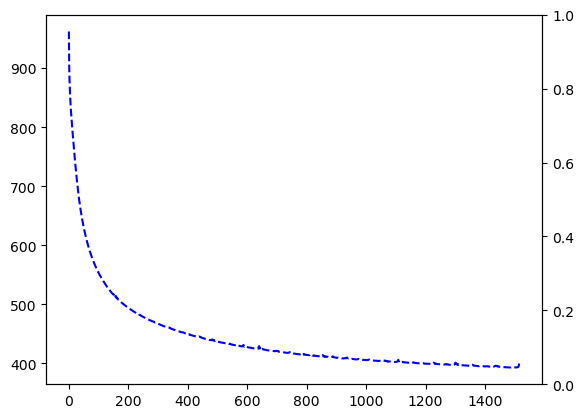

In [364]:
utils.plot_curve(model, config, train_losses, test_losses)

In [ ]:
# sort list by test loss
# sorted_loss = sorted(test_losses, key=lambda x: x[1][1], reverse=True) 
# extract first element after epoch 600
# sorted_loss = [(x[0], x[1][1]/20) for x in sorted_loss if x[0] > 600]
# print(sorted_loss)
# print(test_losses)

In [332]:
# load best model
# model.load_model('best')
# load model from epoch x
model.load_model('best')

Loaded model


In [ ]:
lin_maps = model.vae.linear_maps
# c1, c2 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy()
# print(c1.T.dot(c2)/(np.linalg.norm(c1)*np.linalg.norm(c2)))
c1, c2, c3 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy(), lin_maps[2].weight.detach().numpy()
print("Norms: {}, {}, {}".format(np.linalg.norm(c1), np.linalg.norm(c2), np.linalg.norm(c3)))

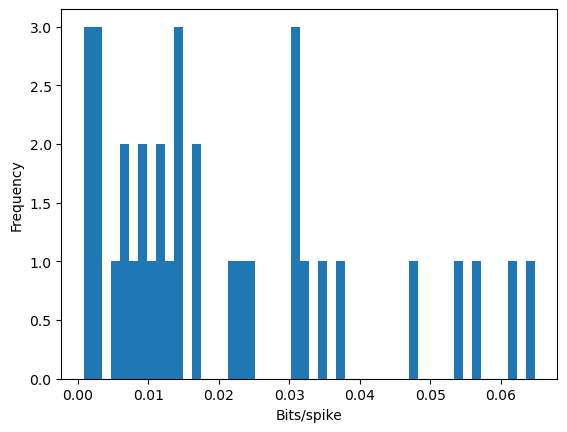

Bits per spike all: 0.7333242893218994, test: 0.7070325016975403


In [365]:
with torch.no_grad():
    model.eval()
    y_recon, (mu, A), _, _ = model.forward(spikes)    
    # run on only test
    y_recon_test, (mu_test, A_test), _, _ = model.forward(spikes_test)
    
# convert to numpy
y_recon_np = y_recon.detach().numpy()
spikes_np = spikes.detach().numpy()
y_recon_test_np = y_recon_test.detach().numpy()
spikes_test_np = spikes_test.detach().numpy()
# compute bits/spike
bits_per_spike_all = utils.bits_per_spike(y_recon_np, spikes_np)
bits_per_spike_test = utils.bits_per_spike(y_recon_test_np, spikes_test_np)
# show distribution of bits per spike
plt.hist(bits_per_spike_all, bins=50)
plt.xlabel('Bits/spike')
plt.ylabel('Frequency')
plt.show()
# print('Bits per spike: {}'.format(bits_per_spike))
print("Bits per spike all: {}, test: {}".format(np.sum(bits_per_spike_all), np.sum(bits_per_spike_test)))

In [ ]:
a_t = np.mean(A.numpy()[:, 20, :, :], axis=0)
cov = a_t * a_t.T
# print(cov.shape, spikes_np.shape)
plt.imshow(cov)
plt.colorbar()

In [ ]:
# plot PSTH of reconstructed and original data
averaged_recon, averaged_original = y_recon.mean(axis=0), spikes_np.mean(axis=0)
# stimulus and choice important
common = [12, 14, 4, 31]
stim_neurons = [15, 11, 33, 30]
choice_neurons = [16, 2, 6, 8]
# plot each in a 5x7 grid
fig, axs = plt.subplots(5, 7, figsize=(12, 9))
# set title of figure
fig.suptitle('yellow: choice, green: stimulus, pink: common')
for i in range(5):
    for j in range(7):
        neuron_idx = i*7+j        
        axs[i, j].plot(averaged_recon[:, neuron_idx], label='recon', color='red')
        axs[i, j].plot(averaged_original[:, neuron_idx], label='original', color='blue')
        # no ticks
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # set title of plot to neuron index
        # print only 2 decimal places        
        axs[i, j].set_title('{}: {:.4f}'.format(neuron_idx, bits_per_spike_all[neuron_idx]))
        # set background color of plot to green if neuron in choice
        if neuron_idx in choice_neurons:
            axs[i, j].set_facecolor('yellow')
        # set background color of plot to red if neuron in stimulus
        if neuron_idx in stim_neurons:
            axs[i, j].set_facecolor('green')
        # set background color of plot to blue if neuron in common
        if neuron_idx in common:
            axs[i, j].set_facecolor('pink')
axs[0, 0].legend()

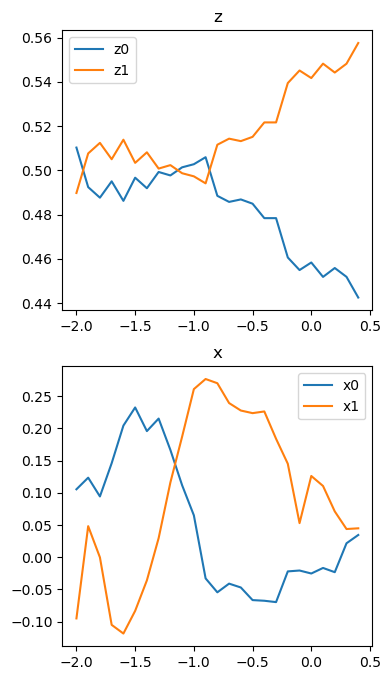

In [366]:
# plot trial averaged latent space
z, x = torch.nn.Softmax(dim=2)(mu[:, :, :model.vae.z_dim]).numpy(), mu[:, :, model.vae.z_dim:].numpy()
# z_std, x_std = np.std(z, axis=0), np.std(x, axis=0)
fig, axs = plt.subplots(2, 1, figsize=(4, 8))
z_avg, x_avg = np.mean(z, axis=0), np.mean(x, axis=0)
# make x ticks of range 0.1 from -2 to 0.5
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
for i in range(z.shape[2]):
    axs[0].plot(t, z_avg[:, i], label='z{}'.format(i))
    axs[1].plot(t, x_avg[:, i], label='x{}'.format(i))
axs[0].set_title('z')
axs[1].set_title('x')
axs[0].legend()
axs[1].legend()

# # plot trial averaged latent space
# z, x = torch.nn.Softmax(dim=2)(mu[:, :, :model.vae.z_dim]).numpy(), mu[:, :, model.vae.z_dim:].numpy()
# z_std, x_std = np.std(z, axis=0), np.std(x, axis=0)
# z_avg, x_avg = np.mean(z, axis=0), np.mean(x, axis=0)
# # make x ticks of range 0.1 from -2 to 0.5
# bin_len = config['shape_dataset']['win_len']
# t = np.arange(-2, 0.5, bin_len)
# for i in range(z.shape[2]):
#     plt.plot(t, z_avg[:, i], label='z{}'.format(i))    
#     plt.fill_between(t, z_avg[:, i]-z_std[:, i], z_avg[:, i]+z_std[:, i], alpha=0.3)
# # plt.set_title('z')
# plt.legend()

In [ ]:
print(model.arch_name)

In [ ]:
def plot_cont_latent(data, label, ax_id, linestyle):
    num_latents = data.shape[1]
    for i in range(num_latents):
        axs[ax_id].plot(t, data[:, i], label='{}_x{}'.format(label, i),
                        color=colors[i], linestyle=linestyle)    
        
colors = ['red', 'blue', 'green', 'yellow']
# group x for stimulus and choice
stim, choice = behaviour_data[:, 0].numpy(), behaviour_data[:, 1].numpy()
# group x for stimulus
x_stim_left, x_stim_right = x[stim == 1].mean(axis=0), x[stim == 0].mean(axis=0)
x_choice_left, x_choice_right = x[choice == 1].mean(axis=0), x[choice == 0].mean(axis=0)
# plot x for stimulus and choice
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_cont_latent(x_stim_left, 'stim left', 0, '-')
plot_cont_latent(x_stim_right, 'stim right', 0, '-.')
axs[0].set_title('x grouped by stimulus')
axs[0].legend()

plot_cont_latent(x_choice_left, 'choice left', 1, '-')
plot_cont_latent(x_choice_right, 'choice right', 1, '-.')
axs[1].set_title('x grouped by choice')
axs[1].legend()


In [367]:
import decoder
with torch.no_grad():
    model.eval()    
    _, (mu_train, A_train), (z_train, x_train), behavior_pred_train = model.forward(spikes_train)
    _, (mu_test, A_test), (z_test, x_test), behavior_pred_test = model.forward(spikes_test)
# if behavior_pred_train is None:
# train the linear decoder for behavior
# create linear decoder
linear_decoder = decoder.CNNDecoder(config, input_dim=2)
optimizer = torch.optim.Adam(linear_decoder.parameters(), lr=0.01)
decoder_train_l, decoder_test_l = [], []
for epoch in range(10):
    linear_decoder.train()
    # forward pass        
    linear_decoder.train()
    behavior_pred = linear_decoder(x_train, z_train)
    # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    loss = linear_decoder.loss(behavior_pred, behaviour_data_train, None)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
    epoch_loss = loss.item()    
    decoder_train_l.append(epoch_loss)
    # test loss
    if (epoch+1) % 1 == 0:
        linear_decoder.eval()
        test_pred = linear_decoder(x_test, z_test)
        # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
        test_loss = linear_decoder.loss(test_pred, behaviour_data_test, None).item()        
        decoder_test_l.append(test_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, decoder_train_l[-1], decoder_test_l[-1]))
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), os.path.join(base_path, 'vae_model_{}.pt'.format(epoch)))
    #     print('Model saved at epoch {}'.format(epoch))
with torch.no_grad():
    behavior_pred_train = linear_decoder(x_train, z_train).detach()
    behavior_pred_test = linear_decoder(x_test, z_test).detach()
    # behavior_pred_train = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    # behavior_pred_test = linear_decoder(mu_test[:, :, :2], mu_test[:, :, 2:])

Scheduler not implemented for decoder


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

In [335]:
num_samples = 100
agg_pred_train, agg_pred_test = [], []
agg_y_train, agg_y_test = [], []

# convert to numpy
y_train = behaviour_data_train.numpy()
y_test = behaviour_data_test.numpy()
# accuracy of stimulus and choice
acc_stim_train, acc_stim_test = [], []
acc_choice_train, acc_choice_test = [], []

with torch.no_grad():
    model.eval()
    for _ in range(num_samples):
        _, (mu_train, A_train), (z_train, x_train), behavior_pred_train = model.forward(spikes_train)
        _, (mu_test, A_test), (z_test, x_test), behavior_pred_test = model.forward(spikes_test)    
        # convert to numpy
        pred_train = behavior_pred_train.numpy() > 0
        pred_test = behavior_pred_test.numpy() > 0
        # compute accuracy
        # print(behaviour_data_train.numpy()[:, 0])
        accuracy_train_stim = accuracy_score(y_train[:, 0], pred_train[:, 0])
        accuracy_test_stim = accuracy_score(y_test[:, 0], pred_test[:, 0])        
        # do the same for choice
        accuracy_train_choice = accuracy_score(y_train[:, 1], pred_train[:, 1])
        accuracy_test_choice = accuracy_score(y_test[:, 1], pred_test[:, 1])
        # append to list
        acc_stim_train.append(accuracy_train_stim)
        acc_stim_test.append(accuracy_test_stim)
        acc_choice_train.append(accuracy_train_choice)
        acc_choice_test.append(accuracy_test_choice)
# print accuracy
print('Stimulus Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_stim_train), np.std(acc_stim_train), np.mean(acc_stim_test), np.std(acc_stim_test)))
print('Choice Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_choice_train), np.std(acc_choice_train), np.mean(acc_choice_test), np.std(acc_choice_test)))

Stimulus Accuracy - train: 0.5272 +- 0.0280, test: 0.5286 +- 0.0439
Choice Accuracy - train: 0.9771 +- 0.0137, test: 0.8853 +- 0.0366


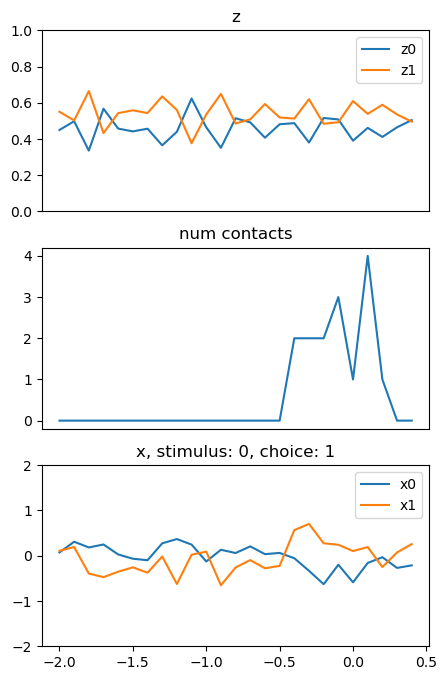

In [368]:
# examine a random trial
trial_idx = np.random.randint(num_trials)
# plot z and x
fig, axs = plt.subplots(3, 1, figsize=(5, 8))
# plot z
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
axs[0].plot(t, z[trial_idx, :, 0], label='z0')
axs[0].plot(t, z[trial_idx, :, 1], label='z1')
# axs[0].plot(t, z[trial_idx, :, 2], label='z2')
axs[0].set_title('z')
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_xticks([])
# plot num contacts
axs[1].plot(t, num_contacts[trial_idx])
axs[1].set_title('num contacts')
axs[1].set_xticks([])
# plot x
axs[2].plot(t, x[trial_idx, :, 0], label='x0')
axs[2].plot(t, x[trial_idx, :, 1], label='x1')
# axs[2].plot(t, x[trial_idx, :, 2], label='x2')
axs[2].set_title('x, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))
axs[2].set_ylim(-2, 2)
axs[2].legend()

In [ ]:
# train a sklearn logistic regression model for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def reshape(x, y):
    trials, time, dim = x.shape
    # x = x[:, -5:-4, :]
    return x.reshape(trials, -1), y

stim_choice = 1

x_train_baseline, y_train_baseline = reshape(spikes_train, behaviour_data_train)
x_test_baseline, y_test_baseline = reshape(spikes_test, behaviour_data_test)

In [ ]:
# train logistic regression model
log_reg = LogisticRegression(penalty='l1', C=1, solver='liblinear', verbose=1)
# log_reg = SVC()
log_reg.fit(x_train_baseline, y_train_baseline[:, stim_choice])
# test accuracy
accuracy_train = accuracy_score(y_train_baseline[:, stim_choice], log_reg.predict(x_train_baseline))
accuracy_test = accuracy_score(y_test_baseline[:, stim_choice], log_reg.predict(x_test_baseline))
print('Logistic Regression Accuracy - train: {:.4f}, test: {:.4f}'.format(accuracy_train, accuracy_test))

In [ ]:
import torch.nn as nn
# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(875, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, loss function, and optimizer
model = LogisticRegressionModel()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 2000
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_baseline)

    # Compute the loss
    loss = criterion(outputs, y_train_baseline[:, stim_choice:stim_choice+1])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Test the model
    with torch.no_grad():    
        predicted_prob = model(x_test_baseline)
        test_losses.append(criterion(predicted_prob, y_test_baseline[:, stim_choice:stim_choice+1]).item())
        predicted_class = (predicted_prob >= 0.5).float()
        accuracy = (predicted_class == y_test_baseline[:, stim_choice:stim_choice+1]).float().mean()
print(f'Accuracy: {accuracy.item():.4f}')


In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [ ]:
# log reg coeff
# plot coefficients in a 2d grid
# c = log_reg.coef_.reshape(-1, 25)
# plt.imshow(c)

# plot nn coefficients
c = model.linear.weight.detach().numpy().reshape(-1, 25)
plt.imshow(c)

In [370]:
# get mean and standard deviation of decoding loss over trials
model.eval()
print("Total models to study:", len(test_losses))
test_losses_aggregated = []
z_agg, x_agg = [], []
cov_norm = []
decoding_runs = 100
for epoch, _ in test_losses[:10] + test_losses[10::20]:
    # print(epoch)
    model.load_model(str(epoch))
    cur_epoch_loss = []
    cur_epoch_z, cur_epoch_x = [], []
    with torch.no_grad():
        cov_norm_current = []
        for _ in range(decoding_runs):
            test_loss = []
            cur_run_z, cur_run_x = [], []
            for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
                y_recon, (mu, A), (z, x), behavior_batch_pred = model(spikes_batch)
                # behavior_loss = model.behavior_decoder.loss(behavior_batch_pred, behavior_batch, z, reduction='none')                
                # test_loss.append(behavior_loss)
                cur_run_z.append(z)
                cur_run_x.append(x)
                cov_norm_current.append(np.linalg.norm(A.numpy()))
            # stack horizontally and take mean across samples
            # test_loss = torch.mean(torch.cat(test_loss, dim=0), dim=0).item()
            # cur_epoch_loss.append(test_loss)
            # stack z and x
            z_stacked, x_stacked = torch.cat(cur_run_z, dim=0), torch.cat(cur_run_x, dim=0)            
            cur_epoch_z.append(z_stacked)
            cur_epoch_x.append(x_stacked)
        
        # test_losses_aggregated.append((epoch, np.mean(cur_epoch_loss), np.std(cur_epoch_loss)))
        # compute std for z and x
        z_std, x_std = torch.std(torch.stack(cur_epoch_z), dim=0), torch.std(torch.stack(cur_epoch_x), dim=0)        
        
        z_agg.append((epoch, z_std.mean().item()))
        x_agg.append((epoch, x_std.mean().item()))
        # cov norm
        cov_norm.append((epoch, np.mean(cov_norm_current)))
# # plot histogram
# plt.hist(test_loss.numpy(), range=(0, 7), bins=50, density=True)
# plt.xlabel('Cross entropy loss')
# plt.ylabel('Frequency')
# plt.title('Test decoding loss')


Total models to study: 343
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model


Text(0.5, 1.0, 'Test decoding loss mean and std over 200 runs at various epochs')

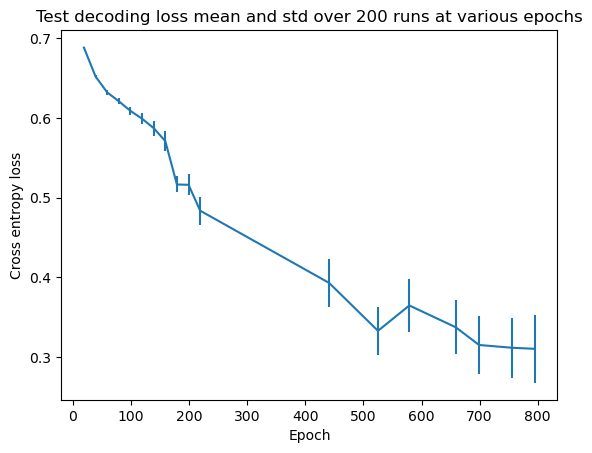

In [338]:
# plot mean and std of test loss
test_losses_plot = np.array(test_losses_aggregated)
plt.errorbar(test_losses_plot[:, 0], test_losses_plot[:, 1], yerr=test_losses_plot[:, 2])
# plt.plot(test_losses_plot[:, 0], test_losses_plot[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
plt.title('Test decoding loss mean and std over 200 runs at various epochs')

[(19, 0.08764678239822388), (39, 0.15095992386341095), (59, 0.14699260890483856), (79, 0.1355198472738266), (99, 0.12364869564771652), (119, 0.11282194405794144), (139, 0.10650033503770828), (159, 0.09894505888223648), (179, 0.09458235651254654), (199, 0.0912485420703888), (219, 0.089748814702034), (619, 0.095258429646492), (783, 0.0920024886727333), (847, 0.09071844071149826), (921, 0.08941783756017685), (995, 0.08832723647356033), (1037, 0.08784403651952744), (1081, 0.08713217079639435), (1121, 0.08741678297519684), (1169, 0.08581339567899704), (1225, 0.08651575446128845), (1273, 0.0860925242304802), (1313, 0.08524720370769501), (1369, 0.08517837524414062), (1409, 0.08523422479629517), (1453, 0.08538820594549179), (1493, 0.08496639877557755)]


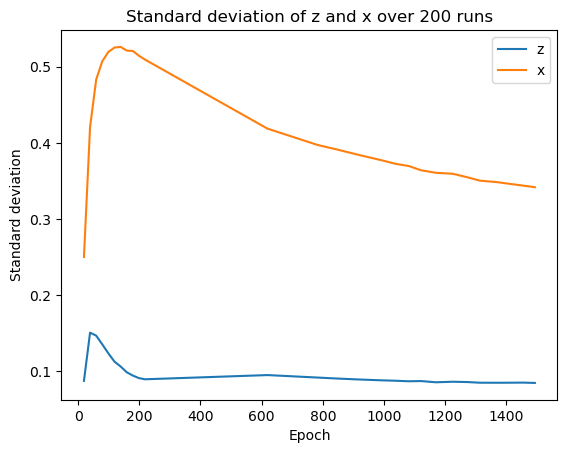

In [371]:
# plot x and z
print(z_agg)
z_agg_plot = np.array(z_agg)
x_agg_plot = np.array(x_agg)
plt.plot(z_agg_plot[:, 0], z_agg_plot[:, 1], label='z')
plt.plot(x_agg_plot[:, 0], x_agg_plot[:, 1], label='x')
plt.xlabel('Epoch')
plt.ylabel('Standard deviation')
plt.title('Standard deviation of z and x over 200 runs')
plt.legend()

Text(0, 0.5, 'Norm of covariance')

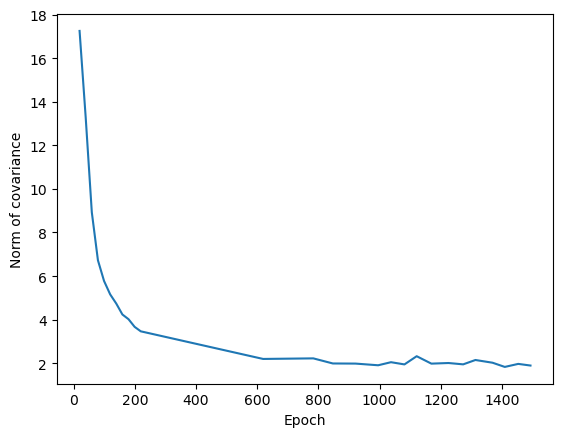

In [372]:
# plot norm of covariance
cov_norm_plot = np.array(cov_norm)
plt.plot(cov_norm_plot[:, 0], cov_norm_plot[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Norm of covariance')

In [316]:
# examine particular examples
# get mean and standard deviation of decoding loss over trials
model.eval()
print("Total models to study:", len(test_losses))
test_losses_aggregated = []
decoding_runs = 100
for epoch, _ in test_losses[:10] + test_losses[10::20]:
    # print(epoch)
    model.load_model(str(epoch))
    cur_epoch_loss = []    
    with torch.no_grad():        
        for _ in range(decoding_runs):
            test_loss = []
            cur_run_z, cur_run_x = [], []
            for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
                y_recon, (mu, A), (z, x), behavior_batch_pred = model(spikes_batch)
                behavior_loss = model.behavior_decoder.loss(behavior_batch_pred, behavior_batch, z, reduction='none')                
                test_loss.append(behavior_loss)                
            # stack horizontally and take mean across samples
            test_loss = torch.cat(test_loss, dim=0)
            cur_epoch_loss.append(test_loss)
        # stack the losses across decoding runs
        cur_epoch_loss = torch.stack(cur_epoch_loss, dim=0)
        # compute mean and std of epoch loss across decoding runs
        m, s = torch.mean(cur_epoch_loss, dim=0).numpy(), torch.std(cur_epoch_loss, dim=0).numpy()        
        test_losses_aggregated.append((epoch, m, s))


Total models to study: 360
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model
Loaded model


In [340]:
for idx in range(15):
    epochs = [x[0] for x in test_losses_aggregated]
    losses = [x[2][idx] for x in test_losses_aggregated]
    plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')

    

IndexError: invalid index to scalar variable.